## Differences in fit algorithms for ellipses - Selina

In this notebook the quality of the two ellipse fitting algorithm is compared.

The evaluation is based on the ground truth (GT) ellipses. They are converted into binary masks.

The algorithm *regionprops* and *fitEllipse* from *cv2* fits ellipses to these binary masks, the differnces to the GT are conpared.

In [1]:
import tensorflow as tf
# TODO: remove after tf2.0 migration
# handle tf API changes 1.x to 2.0
from packaging import version
if version.parse(tf.__version__) < version.parse('2.0'):
    opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=opts))
else:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
## check if tf detected a GPU 
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x for x in local_device_protos if x.device_type == 'GPU']



print("GPU device id: ", tf.test.gpu_device_name())
print("GPU details: \n" , get_available_gpus())

1 Physical GPUs, 1 Logical GPUs
GPU device id:  /device:GPU:0
GPU details: 
 [name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 199622656
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14762621529363740886
physical_device_desc: "device: 0, name: Quadro M4000, pci bus id: 0000:65:00.0, compute capability: 5.2"
]


## Convert mask to ellipse
There are 2 steps to perform. The first is the conversion from a binary mask to individual object edges. We achieve this by the scikit-image methods **label**, which enumerates the individual patches of objects within the mask. Then we use **binary_erosion**, which removes the outer edge of all patches within one mask and XOR the result with the original mask. This yields the edge of the object mask.<br>

Second, we apply the ellipse fitting algoritm -- either **fitEllipse** (cv2) or **regionprops** -- to the pixel positions of the mask edge pixels. 

**FitEllipse** is based on a algebraic distance minimisation process described in [Fitzgibbon95]. **regionprops** is based on the momentum of the image.

<br><br>
Fitzgibbon95: Andrew W. Fitzgibbon, R.B.Fisher. A Buyer’s Guide to Conic Fitting. Proc.5th British Machine Vision Conference, Birmingham, pp. 513-522, 1995. The technique used for ellipse fitting is the first one described in this summary paper.

In [1]:
from skimage.measure import label
from skimage.measure import regionprops
from skimage.morphology import binary_erosion
import cv2
def fit_ellipses(prediction):
    labeled = label(prediction)
    out = []
    for i in range(1, np.amax(labeled)+1):
        mask = labeled==i
        mask = binary_erosion(mask)^mask
        points = np.array(np.where(mask)).T
        if len(points)>=100:
            out.append(cv2.fitEllipse(points))
    return out

def fit_ellipses_regionprops(p):
    labeled = label(p)
    out = []
    for region in regionprops(labeled,p):  
        a = region.major_axis_length / 2
        b = region.minor_axis_length / 2
        r = np.sqrt(a * b)
        circum = np.pi * ((3 * (a + b)) - np.sqrt(10 * a * b + 3 * (a**2 + b**2)))
        if region.area >= 100: #analyze only regions larger than 100 pixels
            # and region.perimeter/circum < 1.06 and region.solidity > 0.95
            fit = ((region.centroid[0],region.centroid[1]),(region.minor_axis_length,region.major_axis_length),90 - np.rad2deg(-region.orientation))
            out.append(fit)
    return out

## Apply to all images
We generate binary masks based no the ground truth ellipses.The actual ellipse fitting is:
```python
mask = np.zeros((img.shape[0:2]), dtype=np.uint8)
for el in q_elli_img:
    #print(el.angle)
    xs,ys = ellipse(el.x, el.y,  el.width/2, el.height/2, rotation=np.deg2rad(el.angle))
    mask[ys,xs] = 1
            
ellipses_n = np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses(mask)])
ellipses_r = np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses_regionprops(mask)])
ellipses_o = np.array([[e.x,e.y,e.width,e.height,e.angle] for e in cdb.getEllipses(image=img_o)])
```
We match the predicted ellipses to the original ones, enabling us to calculate evaluation metrics. For this we use the euclidian distance between a **ground truth** (manual acquired) ellipse and a **system** (redicted by network + opencv) ellipse center as the cost of matching this pair. We match via the **linear_sum_assignment** function implemented in scipy, which builts up on the "hungarian algorithm" by Kuhn and Munkres [Kuhn55].
<br><br>
H. W. Kuhn (1955): The Hungarian method for the assignment problem. Naval Research Logistics Quarterly 2, S. 83–97.

In [31]:
import matplotlib.pyplot as plt
import clickpoints
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse # display only
from skimage.draw import ellipse       # generate binary mask
from PIL import Image
from scipy.optimize import linear_sum_assignment
from matplotlib.patches import Ellipse


search_path = '../data/ml1_raw'
file_list = []
for root, dirs, files in os.walk(search_path):
    for file in files:
        if not file.endswith("ML.cdb"):
            continue
        file_list.append(os.path.abspath(os.path.join(root, file)))

GT = []
Sys = [] # fitEllipse 
SysR = [] # regionprops

GTMatch = []
GTMatchR = []
SysMatch = []
SysMatchR = []

SysMatch_comp = []
SysMatchR_comp = []

id_Sys = []
id_SysR = []

masks = []
for cdb_file in file_list:
    cdb = clickpoints.DataFile(cdb_file)
    cdb_path = os.path.split(cdb_file)[0]
    q_elli = cdb.getEllipses()
    print("#%d found" % q_elli.count())

    # get the image ids which contain at least on ellipse
    img_ids = np.unique([el.image.id for el in q_elli])

    for id in img_ids:
        # get image object by id and image data
        img_o = cdb.getImage(id=id)
        img   = img_o.get_data()
        # get ellipses in this image 
        q_elli_img = cdb.getEllipses(image=img_o)

        mask = np.zeros((img.shape[0:2]), dtype=np.uint8)
        for el in q_elli_img:
            #print(el.angle)
            xs,ys = ellipse(el.x, el.y,  el.width/2, el.height/2, rotation=np.deg2rad(el.angle))
            mask[ys,xs] = 1
        masks.append(mask)
        ellipses_n = np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses(mask)])
        ellipses_r = np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses_regionprops(mask)])
        ellipses_o = np.array([[e.x,e.y,e.width,e.height,e.angle] for e in cdb.getEllipses(image=img_o)])
        
        # Check that long and short axis are correctly assigned, if not change them plus th
        for i in range(np.shape(ellipses_o)[0]):
            if ellipses_o[i,2] < ellipses_o[i,3]:
                #print(ellipses_o)
                x = ellipses_o[i,2]
                ellipses_o[i,2] = ellipses_o[i,3]
                ellipses_o[i,3] = x
                #print(ellipses_o)
                #print(ellipses_n)
                ellipses_o[i,4] = ellipses_o[i,4] - 90
        Sys.extend(ellipses_n)
        SysR.extend(ellipses_r)
        GT.extend(ellipses_o)
        
        if np.shape(ellipses_n)[0] != 0:  # if ellipses_n is [], so no ellipse at all in image
            cost = np.linalg.norm(ellipses_o[None,:,:2]-ellipses_n[:,None,:2], axis=-1)
            sys_ids, gt_ids = linear_sum_assignment(cost)
            
            # Avoiding mismatch if there is no corresponding system ellipse to ground truth ellipse
            index = []
            for i in range(len(sys_ids)):
                if cost[sys_ids[i],gt_ids[i]] > 50:
                    print('Here')
                    index.append(i)
                    print(sys_ids,gt_ids, cost)
            sys_ids = np.delete(sys_ids,index)
            gt_ids = np.delete(gt_ids,index)
            #print(sys_ids,gt_ids)
            
            GTMatch.extend(ellipses_o[gt_ids])
            SysMatch.extend(ellipses_n[sys_ids])
            
            #if np.abs(ellipses_o[gt_ids,2] - ellipses_n[sys_ids,2]) > 3:
             #   print(ellipses_o[gt_ids], ellipses_n[sys_ids])
              #  plt.imshow(mask)
               # plt.show()
            for i in sys_ids:
                id_Sys.append(id)
            # New predicted ellipse in cdb
        if np.shape(ellipses_r)[0] != 0:  
            costR = np.linalg.norm(ellipses_o[None,:,:2]-ellipses_r[:,None,:2], axis=-1)
            sys_ids_r, gt_ids_r = linear_sum_assignment(costR)     
                         
            # costR has to be under a certain value. To assign the correct ellipse!!
            index = []
            for i in range(len(sys_ids_r)):
                if costR[sys_ids_r[i],gt_ids_r[i]] > 50:
                    print('Here R')
                    print(sys_ids_r,gt_ids_r, costR)
                    index.append(i)
            sys_ids_r = np.delete(sys_ids_r,index)
            gt_ids_r = np.delete(gt_ids_r,index)
            #print(sys_ids_r,gt_ids_r)
            
            GTMatchR.extend(ellipses_o[gt_ids_r])
            SysMatchR.extend(ellipses_r[sys_ids_r])
            for i in sys_ids_r:
                id_SysR.append(id)
        try:    
            costSys = np.linalg.norm(ellipses_n[None,:,:2]-ellipses_r[:,None,:2], axis=-1)
            sys_ids_r_comp, sys_ids_comp = linear_sum_assignment(costSys)
            
            SysMatchR_comp.extend(ellipses_r[sys_ids_r_comp])
            sys_texts_comp = np.array(["%d"%i for i in range(len(ellipses_n))])
            sys_texts_r_comp = np.array(["x" for i in range(len(ellipses_r))])
            sys_texts_r_comp[sys_ids_r_comp] = np.array(["%d"%i for i in sys_ids_comp])
            SysMatch_comp.extend(ellipses_n[sys_ids_comp])
        except:
            continue

GT=np.array(GT)

# Matched ellipses with fitEllipse
GTMatch=np.array(GTMatch)
Sys=np.array(Sys)
SysMatch=np.array(SysMatch)

# Matched ellipses with regionprops
GTMatchR=np.array(GTMatchR)
SysR=np.array(SysR)
SysMatchR=np.array(SysMatchR)

# comparison between two different methods
SysMatch_comp=np.array(SysMatch_comp)
SysMatchR_comp=np.array(SysMatchR_comp)

print(np.shape(GT))
print('GT and Sys')
print(np.shape(GTMatch))
print(np.shape(Sys))
print(np.shape(SysMatch))
print('GT and SysR')
print(np.shape(GTMatchR))
print(np.shape(SysR))
print(np.shape(SysMatchR))
print('Same ellipse detected')
print(np.shape(SysMatchR_comp))
print(np.shape(SysMatch_comp))

masks = np.array(masks)

path /tf/data/ml1_raw/ML_p3/ellipsoide_ML.cdb
Open database with version 22
#75 found
path /tf/data/ml1_raw/ML_p2/ellipsoide_ML.cdb
Open database with version 22
#71 found
path /tf/data/ml1_raw/ML_p1/ellipsoide_ML.cdb
Open database with version 22
#136 found
(282, 5)
GT and Sys
(279, 5)
(279, 5)
(279, 5)
GT and SysR
(281, 5)
(281, 5)
(281, 5)
Same ellipse detected
(279, 5)
(279, 5)


In [11]:
font = {'family' : 'sans-serif',
        'sans-serif':['Arial'],
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.rc('legend', fontsize=12)
plt.rc('axes', titlesize=18)    
plt.rcParams['axes.linewidth'] = 0.1 #set the value globally

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


((251.62271118164062, 228.9486083984375), (41.724639892578125, 53.05631637573242), 146.5457305908203)
((459.5833435058594, 245.05062866210938), (31.481107711791992, 61.9132194519043), 14.515743255615234)
((251.62901439645626, 228.94850498338872), (42.58397240634295, 53.99681900151698), 146.36976836547066)
((459.5797373358349, 245.05378361475923), (32.41051753508751, 62.820784713303354), 14.63713905553189)


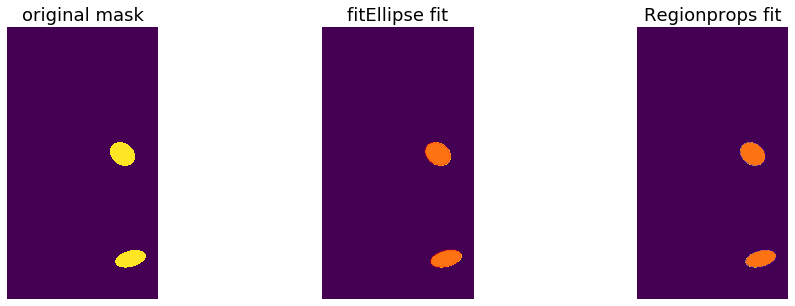

In [12]:
id=42
    
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

fig, axes = plt.subplots(1,3,figsize=[16,5],)
ax=axes[0]
ax.set_title("original mask")
ax.imshow(masks[id])
ax.set_axis_off()

ax=axes[1]
ax.set_title("fitEllipse fit")
ax.imshow(masks[id])
ax.set_axis_off()
ellipses_n = np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses(mask)])
for ell in fit_ellipses(masks[id]):
    print(ell)
    xy, (a,b), phi = ell
    e = Ellipse([xy[1],xy[0]], width=b,height=a, angle=-phi, fill=True,edgecolor = 'r')
    ax.add_artist(e)
    e.set_alpha(0.5)
    e.set_facecolor((1.,0.,0.))

ax=axes[2]
ax.set_title("Regionprops fit")
ax.imshow(masks[id].squeeze())
ax.set_axis_off()
for ell in fit_ellipses_regionprops(masks[id]):
    print(ell)
    xy, (a,b), phi = ell
    e2 = Ellipse([xy[1],xy[0]], width=b,height=a, angle=-phi, fill=True, edgecolor = 'b',linestyle='--')
    ax.add_artist(e2)
    e2.set_alpha(0.5)
    e2.set_facecolor((1.,0.,0.))
    #e.set_edgecolor(('r'))
    #print(np.array([[y,x,b,a,-phi] for (x,y), (a,b), phi in fit_ellipses_regionprops(prediction.squeeze()>0.5)]))

## Measure quality of prediction
We measure the discrepancy between the matched pairs of ellipses in all 5 ellipse attributes: center X position, center Y position, long semiaxis, short semiaxis and skew angle.

## FitEllipse from cv2

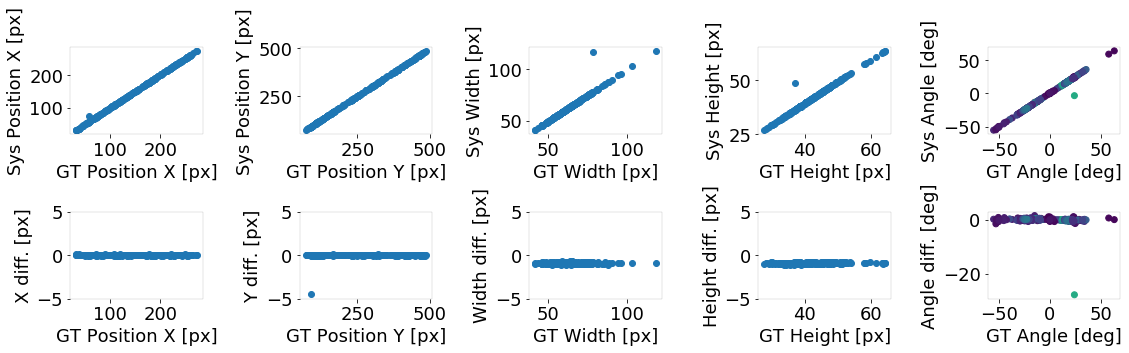

In [17]:
fig, axes = plt.subplots(2,5,figsize=[16,5],)
axes=np.array(axes)

ax = axes[0,0]
ax.scatter(GTMatch[:,0],SysMatch[:,0])
ax.set_xlabel("GT Position X [px]")
ax.set_ylabel("Sys Position X [px]")

ax = axes[0,1]
ax.scatter(GTMatch[:,1],SysMatch[:,1])
ax.set_xlabel("GT Position Y [px]")
ax.set_ylabel("Sys Position Y [px]")

ax = axes[0,2]
ax.scatter(GTMatch[:,2], SysMatch[:,2])
ax.set_xlabel("GT Width [px]")
ax.set_ylabel("Sys Width [px]")

ax = axes[0,3]
ax.scatter(GTMatch[:,3], SysMatch[:,3])
ax.set_xlabel("GT Height [px]")
ax.set_ylabel("Sys Height [px]")

ax = axes[0,4]
gt_phi = (GTMatch[:,4]-90*(GTMatch[:,2]<GTMatch[:,3])+90)%360 -90
sys_phi = (SysMatch[:,4]+90)%180 -90
maped = ax.scatter(gt_phi, sys_phi, c=GTMatch[:,2]/GTMatch[:,3])
ax.set_xlabel("GT Angle [deg]")
ax.set_ylabel("Sys Angle [deg]")

ax = axes[1,0]
ax.scatter(GTMatch[:,0],(SysMatch[:,0]-GTMatch[:,0]))
ax.set_ylim(-5,5)
ax.set_xlabel("GT Position X [px]")
ax.set_ylabel("X diff. [px]")

ax = axes[1,1]
ax.scatter(GTMatch[:,1],(SysMatch[:,1]-GTMatch[:,1]))
ax.set_ylim(-5,5)
ax.set_xlabel("GT Position Y [px]")
ax.set_ylabel("Y diff. [px]")

ax = axes[1,2]
ax.scatter(GTMatch[:,2], (SysMatch[:,2]-GTMatch[:,2]))
ax.set_ylim(-5,5)
ax.set_xlabel("GT Width [px]")
ax.set_ylabel("Width diff. [px]")

ax = axes[1,3]
ax.scatter(GTMatch[:,3], (SysMatch[:,3]-GTMatch[:,3]))
ax.set_ylim(-5,5)
ax.set_xlabel("GT Height [px]")
ax.set_ylabel("Height diff. [px]")

ax = axes[1,4]
gt_phi = (GTMatch[:,4]-90*(GTMatch[:,2]<GTMatch[:,3])+90)%360 - 90
sys_phi = (SysMatch[:,4]+90)%180 -90
ax.scatter(gt_phi, (sys_phi-gt_phi), c=GTMatch[:,2]/GTMatch[:,3])
ax.set_xlabel("GT Angle [deg]")
ax.set_ylabel("Angle diff. [deg]")

fig.tight_layout()
#plt.savefig('/tf/results3/evaluations/' + network + 'GT_vs_Sys.png')

In [18]:
np.max(abs(sys_phi-gt_phi))

27.808486160541335

X Position difference: -0.07 +- 1.19
Y Position difference: 0.01 +- 0.27
Width Position difference: 0.76 +- 2.31
Height Position difference: 0.86 +- 0.73
Angle Position difference: -0.11 +- 1.70


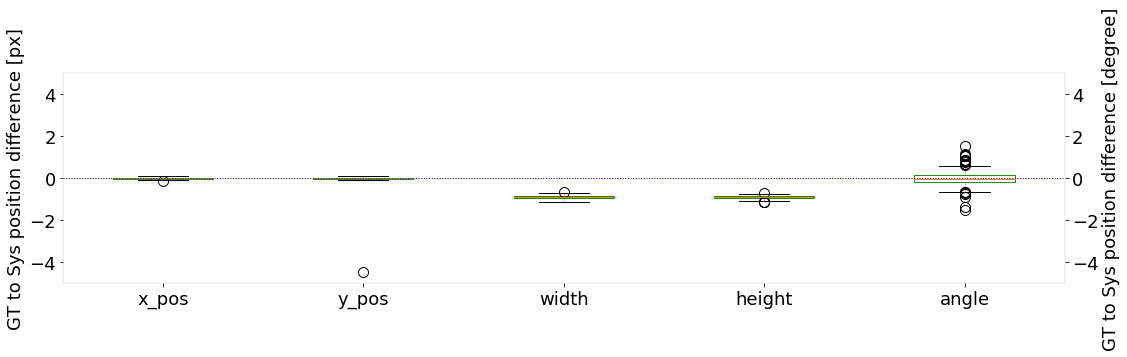

In [19]:
x_pos_diff = GTMatch[:,0]-SysMatch[:,0]
y_pos_diff = GTMatch[:,1]-SysMatch[:,1]
width_diff = GTMatch[:,2]-SysMatch[:,2]
height_diff = GTMatch[:,3]-SysMatch[:,3]
angle_diff = (SysMatch[:,4]+90)%180 -90 - ((GTMatch[:,4]-90*(GTMatch[:,2]<GTMatch[:,3])+90)%360 -90)

differences = [-x_pos_diff,-y_pos_diff,-width_diff,-height_diff,angle_diff]

fig, ax = plt.subplots(figsize=[16,5])
ticks = ['x-pos', 'y-pos', 'width', 'height', 'angle']
line_props = dict(color="r", alpha=0.3)
bbox_props = dict(color="g", alpha=0.9)
flier_props = dict(marker="o", markersize=10)
ax.set_ylim(-5,5)
plt.boxplot(differences, whiskerprops=line_props, boxprops=bbox_props, flierprops=flier_props)

ax.set_xticklabels(['x_pos', 'y_pos', 'width', 'height', 'angle'])
ax.set_ylabel('GT to Sys position difference [px]')

ax2 = fig.add_subplot(111, sharex=ax, frameon=False)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylim(-5,5)
ax2.set_ylabel("GT to Sys position difference [degree]")
plt.axhline(linewidth=1,color='b',linestyle=':')

plt.tight_layout()
#
#plt.savefig('/tf/results3/evaluations/' + network + 'boxplots_GT_vs_Sys.png')

print('X Position difference: %.2f +- %.2f' % (np.mean(x_pos_diff), np.std(x_pos_diff)))
print('Y Position difference: %.2f +- %.2f' % (np.mean(y_pos_diff), np.std(y_pos_diff)))
print('Width Position difference: %.2f +- %.2f' % (np.mean(width_diff), np.std(width_diff)))
print('Height Position difference: %.2f +- %.2f' % (np.mean(height_diff), np.std(height_diff)))
print('Angle Position difference: %.2f +- %.2f' % (np.mean(angle_diff), np.std(angle_diff)))


## Regionprops

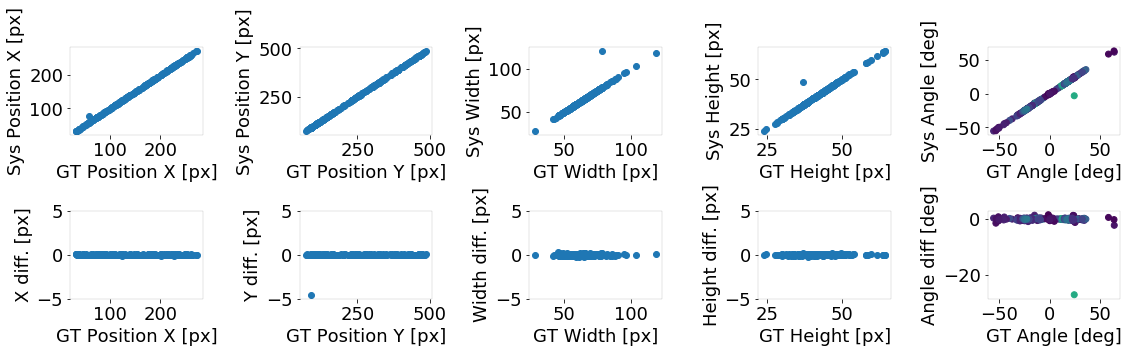

In [20]:
fig, axes = plt.subplots(2,5,figsize=[16,5],)
axes=np.array(axes)

ax = axes[0,0]
ax.scatter(GTMatchR[:,0],SysMatchR[:,0])
ax.set_xlabel("GT Position X [px]")
ax.set_ylabel("Sys Position X [px]")

ax = axes[0,1]
ax.scatter(GTMatchR[:,1],SysMatchR[:,1])
ax.set_xlabel("GT Position Y [px]")
ax.set_ylabel("Sys Position Y [px]")

ax = axes[0,2]
ax.scatter(GTMatchR[:,2], SysMatchR[:,2])
ax.set_xlabel("GT Width [px]")
ax.set_ylabel("Sys Width [px]")

ax = axes[0,3]
ax.scatter(GTMatchR[:,3], SysMatchR[:,3])
ax.set_xlabel("GT Height [px]")
ax.set_ylabel("Sys Height [px]")

ax = axes[0,4]
gt_phi = (GTMatchR[:,4]-90*(GTMatchR[:,2]<GTMatchR[:,3])+90)%360 -90
sys_phi = (SysMatchR[:,4]+90)%180 -90
maped = ax.scatter(gt_phi, sys_phi, c=GTMatchR[:,2]/GTMatchR[:,3])
ax.set_xlabel("GT Angle [deg]")
ax.set_ylabel("Sys Angle [deg]")

ax = axes[1,0]
ax.scatter(GTMatchR[:,0],(SysMatchR[:,0]-GTMatchR[:,0]))
ax.set_ylim(-5,5)
ax.set_xlabel("GT Position X [px]")
ax.set_ylabel("X diff. [px]")

ax = axes[1,1]
ax.scatter(GTMatchR[:,1],(SysMatchR[:,1]-GTMatchR[:,1]))
ax.set_ylim(-5,5)
ax.set_xlabel("GT Position Y [px]")
ax.set_ylabel("Y diff. [px]")

ax = axes[1,2]
ax.scatter(GTMatchR[:,2], (SysMatchR[:,2]-GTMatchR[:,2]))
ax.set_ylim(-5,5)
ax.set_xlabel("GT Width [px]")
ax.set_ylabel("Width diff. [px]")

ax = axes[1,3]
ax.scatter(GTMatchR[:,3], (SysMatchR[:,3]-GTMatchR[:,3]))
ax.set_ylim(-5,5)
ax.set_xlabel("GT Height [px]")
ax.set_ylabel("Height diff. [px]")

ax = axes[1,4]
gt_phi = (GTMatchR[:,4]-90*(GTMatchR[:,2]<GTMatchR[:,3])+90)%360 -90
sys_phi = (SysMatchR[:,4]+90)%180 -90
ax.scatter(gt_phi, (sys_phi-gt_phi), c=GTMatchR[:,2]/GTMatchR[:,3])
ax.set_xlabel("GT Angle [deg]")
ax.set_ylabel("Angle diff [deg]")

fig.tight_layout()
#plt.savefig('/tf/results3/evaluations/' + network + 'GT_vs_Sys_R.png')

X Position difference: -0.08 +- 1.30
Y Position difference: 0.01 +- 0.28
Width Position difference: -0.15 +- 2.51
Height Position difference: -0.04 +- 0.69
Angle Position difference: -0.09 +- 1.66


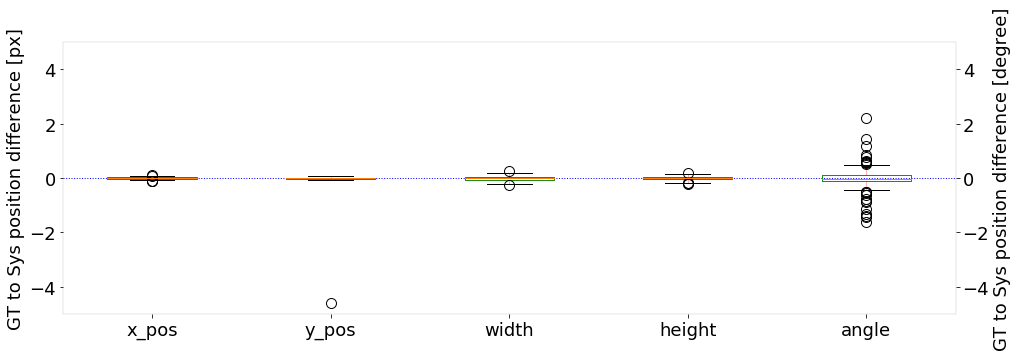

In [21]:
x_pos_diff = GTMatchR[:,0]-SysMatchR[:,0]
y_pos_diff = GTMatchR[:,1]-SysMatchR[:,1]
width_diff = GTMatchR[:,2]-SysMatchR[:,2]
height_diff = GTMatchR[:,3]-SysMatchR[:,3]
angle_diff = (SysMatchR[:,4]+90)%180 -90 - ((GTMatchR[:,4]-90*(GTMatchR[:,2]<GTMatchR[:,3])+90)%360 -90)

differencesR = [-x_pos_diff,-y_pos_diff,-width_diff,-height_diff,-angle_diff]

fig, ax = plt.subplots(figsize=[16,5])

line_props = dict(color="r", alpha=0.3)
bbox_props = dict(color="g", alpha=0.9)
flier_props = dict(marker="o", markersize=10)
ax.set_ylim(-5,5)
ax.set_xticklabels(['x_pos', 'y_pos', 'width', 'height', 'angle'])
ax.set_ylabel('GT to Sys position difference [px]')

ax2 = fig.add_subplot(111, sharex=ax, frameon=False)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylim(-5,5)
ax2.set_ylabel("GT to Sys position difference [degree]")
plt.axhline(linewidth=1,color='b',linestyle=':')


plt.boxplot(differencesR, whiskerprops=line_props, boxprops=bbox_props, flierprops=flier_props)
#
#plt.savefig('/tf/results3/evaluations/' + network + 'boxplot_GT_vs_Sys_R.png')

print('X Position difference: %.2f +- %.2f' % (np.mean(x_pos_diff), np.std(x_pos_diff)))
print('Y Position difference: %.2f +- %.2f' % (np.mean(y_pos_diff), np.std(y_pos_diff)))
print('Width Position difference: %.2f +- %.2f' % (np.mean(width_diff), np.std(width_diff)))
print('Height Position difference: %.2f +- %.2f' % (np.mean(height_diff), np.std(height_diff)))
print('Angle Position difference: %.2f +- %.2f' % (np.mean(angle_diff), np.std(angle_diff)))

In [22]:
print(GTMatchR[1])
print(SysMatchR[1])
print(SysMatch[1])
print(GTMatch[1])

[214.97191011 162.0505618   65.25802651  34.38202247  10.26514046]
[ 214.95501139  162.03587699   65.36309416   34.20553188 -169.7719726 ]
[ 214.96028137  162.02830505   64.49282074   33.25806427 -169.94985962]
[214.97191011 162.0505618   65.25802651  34.38202247  10.26514046]


# Comparison between regionprops and fitEllipse

One set of Ellipses is fitted with the cv2 algorithm fitEllipse and the other is fitted with the regionprops algorithm

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


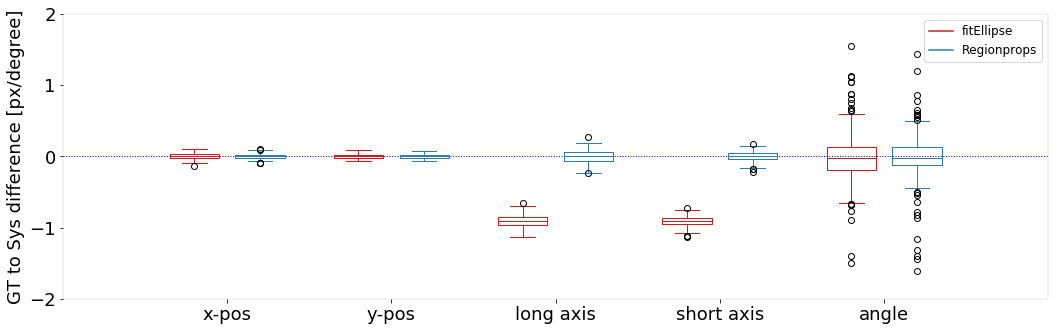

In [23]:
import matplotlib.pyplot as plt
import numpy as np

font = {'family' : 'sans-serif',
        'sans-serif':['Arial'],
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.rc('legend', fontsize=12)
plt.rc('axes', titlesize=18)    
plt.rcParams['axes.linewidth'] = 0.1 #set the value globally

data_a = differences
data_b = differencesR
#plt.rc('axes', labelsize=12) 
ticks = ['x-pos', 'y-pos', 'long axis', 'short axis', 'angle']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

fig, ax = plt.subplots(figsize=[15,5])
bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, widths=0.6)
bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='fitEllipse')
plt.plot([], c='#2C7BB6', label='Regionprops')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.ylim(-2,2)
plt.axhline(linewidth=1,color='b',linestyle=':')

ax.set_ylabel('GT to Sys difference [px/degree]')

plt.tight_layout()
#plt.savefig('/tf/results/results_new/' + 'Fitting_ellipses.png')


fitEllipse matches smaller ellipses than the regionprops algorithm!

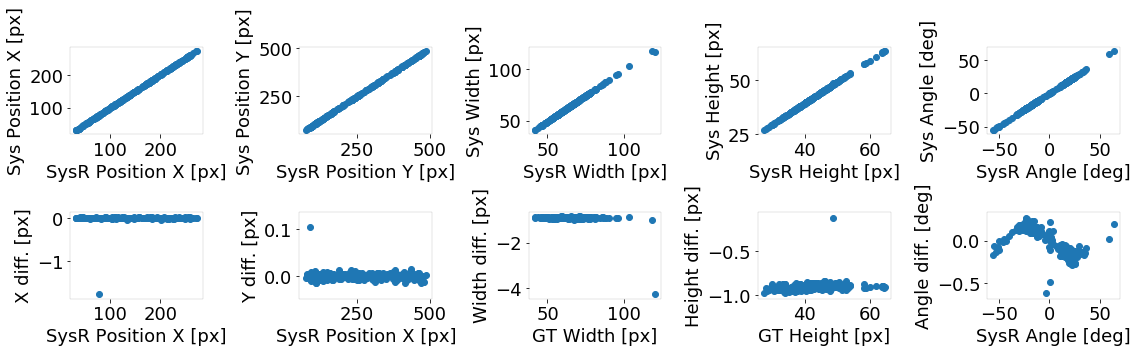

In [27]:
# Differences between the two fitting algorithms

fig, axes = plt.subplots(2,5,figsize=[16,5],)
axes=np.array(axes)

ax = axes[0,0]
ax.scatter(SysMatchR_comp[:,0],SysMatch_comp[:,0])
ax.set_xlabel("SysR Position X [px]")
ax.set_ylabel("Sys Position X [px]")

ax = axes[0,1]
ax.scatter(SysMatchR_comp[:,1],SysMatch_comp[:,1])
ax.set_xlabel("SysR Position Y [px]")
ax.set_ylabel("Sys Position Y [px]")

ax = axes[0,2]
ax.scatter(SysMatchR_comp[:,2], SysMatch_comp[:,2])
ax.set_xlabel("SysR Width [px]")
ax.set_ylabel("Sys Width [px]")

ax = axes[0,3]
ax.scatter(SysMatchR_comp[:,3], SysMatch_comp[:,3])
ax.set_xlabel("SysR Height [px]")
ax.set_ylabel("Sys Height [px]")

ax = axes[0,4]
ax.scatter((SysMatchR_comp[:,4]+90)%180 -90, (SysMatch_comp[:,4]+90)%180 -90)
ax.set_xlabel("SysR Angle [deg]")
ax.set_ylabel("Sys Angle [deg]")

ax = axes[1,0]
ax.scatter(SysMatchR_comp[:,0],(SysMatch_comp[:,0]-SysMatchR_comp[:,0]))
#ax.set_ylim(0,5)
ax.set_xlabel("SysR Position X [px]")
ax.set_ylabel("X diff. [px]")

ax = axes[1,1]
ax.scatter(SysMatchR_comp[:,1],(SysMatch_comp[:,1]-SysMatchR_comp[:,1]))
#ax.set_ylim(0,5)
ax.set_xlabel("SysR Position X [px]")
ax.set_ylabel("Y diff. [px]")

ax = axes[1,2]
ax.scatter(SysMatchR_comp[:,2], (SysMatch_comp[:,2]-SysMatchR_comp[:,2]))
#ax.set_ylim(0,10)
ax.set_xlabel("GT Width [px]")
ax.set_ylabel("Width diff. [px]")

ax = axes[1,3]
ax.scatter(SysMatchR_comp[:,3], (SysMatch_comp[:,3]-SysMatchR_comp[:,3]))
#ax.set_ylim(0,10)
ax.set_xlabel("GT Height [px]")
ax.set_ylabel("Height diff. [px]")

ax = axes[1,4]
ax.scatter((SysMatchR_comp[:,4]+90)%180 -90, ((SysMatch_comp[:,4]+90)%180 -90-((SysMatchR_comp[:,4]+90)%180 -90)))
ax.set_xlabel("SysR Angle [deg]")
ax.set_ylabel("Angle diff. [deg]")

fig.tight_layout()
#plt.savefig('/tf/results3/evaluations/' + network + 'SysR_vs_Sys.png')

X Position difference: -0.01 +- 0.11 
Y Position difference: 0.00 +- 0.01
Width Position difference: -0.91 +- 0.20, Regionprops fits greater values
Height Position difference: -0.90 +- 0.05, Regionprops fits greater values
Angle Position difference: 0.61 +- 10.73


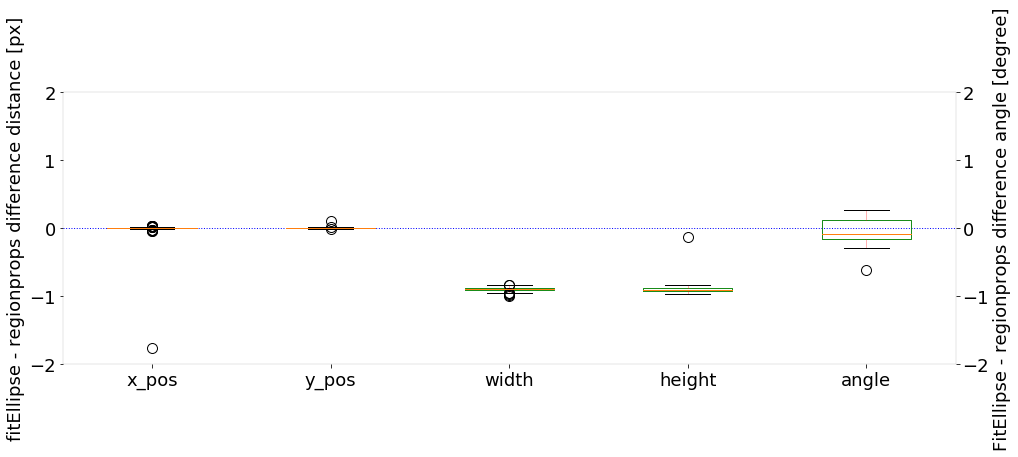

In [28]:
x_pos_diff = SysMatch_comp[:,0]-SysMatchR_comp[:,0]
y_pos_diff = SysMatch_comp[:,1]-SysMatchR_comp[:,1]
width_diff = SysMatch_comp[:,2]-SysMatchR_comp[:,2]
height_diff = SysMatch_comp[:,3]-SysMatchR_comp[:,3]
angle_diff = SysMatch_comp[:,4]-SysMatchR_comp[:,4]

differencesSys = [x_pos_diff,y_pos_diff,width_diff,height_diff,angle_diff]

fig, ax = plt.subplots(figsize=[16,5])

line_props = dict(color="r", alpha=0.3)
bbox_props = dict(color="g", alpha=0.9)
flier_props = dict(marker="o", markersize=10)
ax.set_ylim(-2,2)
ax.set_xlim(0.5,5.5)
ax.set_xticklabels(['x_pos', 'y_pos', 'width', 'height', 'angle'])
ax.set_ylabel('fitEllipse - regionprops difference distance [px]')
plt.axhline(linewidth=1,color='b',linestyle=':')

ax2 = fig.add_subplot(111, sharex=ax, frameon=False)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylim(-2,2)
ax2.set_ylabel("FitEllipse - regionprops difference angle [degree]")

plt.boxplot(differencesSys, whiskerprops=line_props, boxprops=bbox_props, flierprops=flier_props)
#plt.savefig('/tf/results3/evaluations/' + network + 'boxplot_Sys_Comparison.png')

print('X Position difference: %.2f +- %.2f ' % (np.mean(x_pos_diff), np.std(x_pos_diff)))
print('Y Position difference: %.2f +- %.2f' % (np.mean(y_pos_diff), np.std(y_pos_diff)))
print('Width Position difference: %.2f +- %.2f, Regionprops fits greater values' % (np.mean(width_diff), np.std(width_diff)))
print('Height Position difference: %.2f +- %.2f, Regionprops fits greater values' % (np.mean(height_diff), np.std(height_diff)))
print('Angle Position difference: %.2f +- %.2f' % (np.mean(angle_diff), np.std(angle_diff)))

In [16]:
print(np.mean(GTMatchR[:,2]))
print(np.mean(SysMatchR[:,3]))
print(np.mean(GTMatch[:,2]))
print(np.mean(GTMatch[:,3]))

64.43604824293558
42.135854884767795
64.4253309658464
42.33215699570647
